In [1]:
%load_ext autoreload
%autoreload 2

#------------------------Necessary Imports------------------------#
# pyclarify functionality:
from pyclarify import ClarifyClient, query, SignalInfo, DataFrame
# matplotlib for visualization inside the notebook (not vital for final forecasting tool)
import matplotlib.pyplot as plt
# this 'package', which depends on (xarray, numpy, scipy, pandas, datetime)
from forecast_clarify.main import *

### 1) Find the Item ID for a time series at a specified station
here: measured ocean temperature at 3m depth at Langøy

In [2]:
client = ClarifyClient('../data/credentials/credentials_ow_persistence.json')

response = client.select_items(include_dataframe=False,limit=50) # can limit be set so that it looks for all possible/accessible IDs?
item_dict = response.result.items

sea_temp_list = [[id,meta] for id,meta in item_dict.items() if 'Sjøtemperatur' in meta.name]
sea_temp_dict = {}
for stl in sea_temp_list:
    sea_temp_dict[stl[0]] = stl[1]

station = 'Langøy'

item_id = [id for id,meta in sea_temp_dict.items() if (station in meta.labels['site']) and ('3 m' in meta.labels['depth']) and ('Embicon' in meta.labels['data-source'])]

<div class="alert alert-block alert-warning">
<b>Questions:</b>
<ol>
 <li>Is there a way to request all available IDs other than setting <code>limit</code> to some arbitrary (large) number?</li>
</ol>
</div>

### 2) Retrieve desired data from clarify
use `rollup = 'P7DT'` to get weekly means 

In [3]:
filter = query.Filter(fields={"id": query.In(value=item_id)})
response_filtered = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2010-05-01T00:00:00Z",
    before = datetime.today(),
    rollup = "P7DT"
)
# question: is the time tag that comes out of the rollup the center of the window?

st3m_langoey = response_filtered.result.data.to_pandas()

print('First Available Date:\t{0:}\nLast Available Date:\t{1:}'.format(st3m_langoey.index[0],st3m_langoey.index[-1]))

First Available Date:	2019-04-08 00:00:00+00:00
Last Available Date:	2022-07-18 00:00:00+00:00


<div class="alert alert-block alert-warning">
<b>Questions:</b>
<ol>
 <li>With <code>rollup</code> set to some value, do the data points get a time tag that refers to the center of the aggregation window?</li>
 <li>Is there a better way to retrieve all available data than to set <code>not_before</code> to some arbitrary date in the (distant) past?</li>
 <li>Is it possible to directly require a minimum number of measurements in an aggregation window, e.g. to require count to be at least 10 and otherwise return <code>NaN</code>?</li>
</ol>
</div>

### 2) Estimate seasonal cycle of temperatures 

In [4]:
# Initialize a seas_cycle object with the time series and the number of harmonics to fit
# note that time coordinate will get converted to day of year
SC = seas_cycle(st3m_langoey.ca8dhakpllnee2k58qfg_avg,nharm=3)
# estimate parameters of the harmonic fit:
SC.fit()
# compute the anomalies from the input data with respect to the estimated seasonal cycle:
SC.training_anomalies()

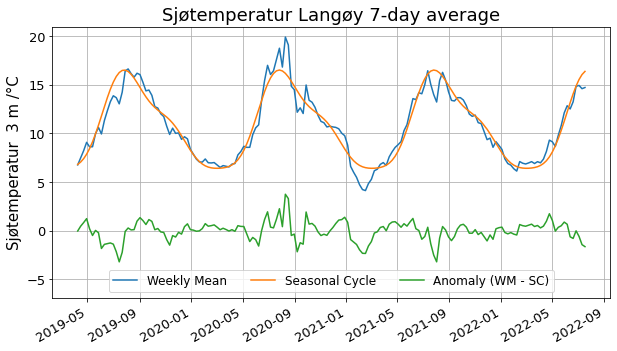

In [5]:
f,ax = plt.subplots(figsize=(10,5))

SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C0',label='Weekly Mean')
SC.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C1',label='Seasonal Cycle')
SC.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C2',label='Anomaly (WM - SC)')

ax.legend(loc=8,fontsize=12,ncol=3)
ax.set_ylim([-7,21])
ax.set_ylabel('{0:s}  {1:s} /{2:s}'.format(
        response_filtered.result.items[item_id[0]].name,
        response_filtered.result.items[item_id[0]].labels['depth'][0],
        response_filtered.result.items[item_id[0]].engUnit
    ),
    fontsize=15
);
ax.set_title('{0:s} {1:s} 7-day average'.format(
        response_filtered.result.items[item_id[0]].name,
        response_filtered.result.items[item_id[0]].labels['site'][0]
    ),
    fontsize=18
);
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.grid()

### 3) Estimate the persistence parameter
Currently, this simply computes a lag-correlation of the entire time series of **anomalies**

In [6]:
# Create a persistence object and initialize with the number of lags to be returned
anom_pers = persistence(lags=4)
# Estimate the persistence parameter
anom_pers.fit(SC.anomalies.ca8dhakpllnee2k58qfg_avg)

### 4) Final forecast of absolute temperatures
The final forecast is simply the sum of the seasonal cycle at a point in time plus an anomaly estimated from the persistence of temperature anomalies 

In [7]:
# prediction of the anomaly:
anom_pred = anom_pers.predict(SC.anomalies.ca8dhakpllnee2k58qfg_avg.isel(time=-1)) # input: initial condition of the forecast

# prediction of seasonal cycle:
sc_pred = SC.predict(anom_pred.time_doy,time_name='lags')

# prediction of the absolute temperature is the seasonal cycle plus the predicted anomaly:
abs_pred = anom_pred + sc_pred

Visualize this:

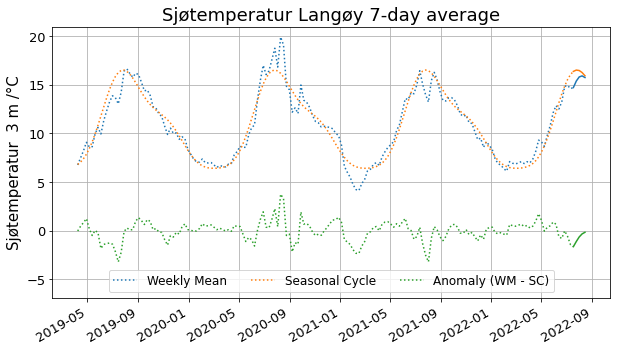

In [8]:
f,ax = plt.subplots(figsize=(10,5))

# Plot observations:
SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C0',label='Weekly Mean',ls='dotted')
SC.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C1',label='Seasonal Cycle',ls='dotted')
SC.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C2',label='Anomaly (WM - SC)',ls='dotted')

# Plot predictions:
anom_pred.plot(ax=ax,x='time',color='C2')
sc_pred.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,x='time',color='C1')
abs_pred.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,x='time',color='C0')

# Brush up the plot a bit:
ax.legend(loc=8,fontsize=12,ncol=3)
ax.set_ylim([-7,21])
ax.set_ylabel('{0:s}  {1:s} /{2:s}'.format(
        response_filtered.result.items[item_id[0]].name,
        response_filtered.result.items[item_id[0]].labels['depth'][0],
        response_filtered.result.items[item_id[0]].engUnit
    ),
    fontsize=15
);
ax.set_title('{0:s} {1:s} 7-day average'.format(
        response_filtered.result.items[item_id[0]].name,
        response_filtered.result.items[item_id[0]].labels['site'][0]
    ),
    fontsize=18
);
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.grid()

### 5) Send the new signal back to clarify
both weekly mean observations *and* forecast are written back

In [9]:
# write values to list
obs_fc_list = list(np.concatenate((st3m_langoey.ca8dhakpllnee2k58qfg_avg.values, abs_pred.ca8dhakpllnee2k58qfg_avg.values), axis=None))
# write corresponding dates to list:
obs_fc_time_list = list(np.concatenate((st3m_langoey.ca8dhakpllnee2k58qfg_avg.index.values, abs_pred.ca8dhakpllnee2k58qfg_avg.time.values), axis=None))

In [10]:
# Define signal metadata:
signal_name = '{0:s} observations_forecast'.format(response_filtered.result.items[item_id[0]].name)
signal_desc = 'Observations and Persistence forecast of 7-day averages up to 4 weeks ahead'
signal_unit = response_filtered.result.items[item_id[0]].engUnit
signal_labels = {'data-source':['Observations + Persistence Model'],'site':response_filtered.result.items[item_id[0]].labels['site'],'depth':response_filtered.result.items[item_id[0]].labels['depth']}

# Create a signal and write metadata to it
signal = SignalInfo(name = signal_name, description = signal_desc, engUnit = signal_unit, labels = signal_labels, sourceType = 'prediction')
client.save_signals(input_ids=['obs_persistence_fc'], signals=[signal], create_only=False)
# Write data into a signal
data_obs_fc = DataFrame(series={'obs_persistence_fc': obs_fc_list}, times = obs_fc_time_list)
client.insert(data_obs_fc)

Response(jsonrpc='2.0', id='1', result=InsertResponse(signalsByInput={'obs_persistence_fc': InsertSummary(id='cbck8a4pllneqtdca4qg', created=False)}), error=None)

<div class="alert alert-block alert-warning">
<b>Questions:</b>
<ol>
 <li>Can we somehow write this back and indicate which part is the observations and which part is the forecast? Do these need to be different signals that then need to be added separately to a timeline?</li>
 <li>What is the best way to write back forecasts (+ observations) for a potentially large number of stations?</li>
 </ol>
</div>